In [21]:
import io
import uuid
from xml.etree import ElementTree
import requests
import scipy.stats as st
from matplotlib import colors
import matplotlib
import numpy as np
import pandas as pd
import datetime
import statistics
import csv
import matplotlib.gridspec as gridspec
from pathlib import Path
import statistics
from rdflib import Graph, ConjunctiveGraph, Namespace, OWL, Literal, URIRef, BNode, XSD, RDFS, RDF
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
import networkx.algorithms.community as nx_comm
from cdlib import algorithms
import matplotlib.pyplot as plt
from cdlib import evaluation
from cdlib import TemporalClustering
from cdlib.algorithms import louvain
from cdlib import algorithms, viz
from src import hintohg
from src import dynamic_cd
from src import cd
from src import attributes
from src import description
from src import vizualisation
from collections import Counter
import pickle

<h1>Defining metapath queries</h1>

In [22]:
# Illustrator - Book - Illustrator
BIB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
           GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {

            ?b a schema:Book ;
                schema:illustrator ?w1, ?w2 ;
                schema:publication ?publicationEvent .

            ?publicationEvent a schema:PublicationEvent .

            OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt} .

            OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et} .

            FILTER(?w1 != ?w2)
            FILTER(STR(?w1) < STR(?w2))
            }
        }"""
# Contributor - Book - Contributor
BCB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {
                        
                        ?b schema:contributor ?w1, ?w2 ;
                                schema:publication ?publicationEvent .
                        
                        # Iets expliciet maken helpt altijd voor de query-processor.
                        ?publicationEvent a schema:PublicationEvent .
                        
                        OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. 
                        OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                        
                        FILTER(?w1 != ?w2).
                        # FILTER(?w1 < ?w2) # RDF kent geen volgorde 
                }
        }"""
# Contributor/Illustrator/Publisher - Book - Contributor/Illustrator/Publisher
BCPIB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
                PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
                PREFIX schema: <http://schema.org/>
                PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
                SELECT * WHERE {
                
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {

                ?b schema:illustrator|schema:contributor|schema:publication/schema:publishedBy ?w1, ?w2 ;
                        schema:publication ?publicationEvent .
                
                # Iets expliciet maken helpt altijd voor de query-processor.
                ?publicationEvent a schema:PublicationEvent .
                
                OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. # Typo in de STCN
                OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                # OPTIONAL { ?bt a ?type}.  # Typo in de STCN
                
                FILTER(?w1 != ?w2)
                FILTER(STR(?w1) < STR(?w2))
}}"""


metapaths = { "BIB" : BIB,
              "BCB" : BCB,
              "BCPIB" : BCPIB,
            }

<h1>Importing the graph based on selected metapath</h1>

Dataframes imported
HG imported


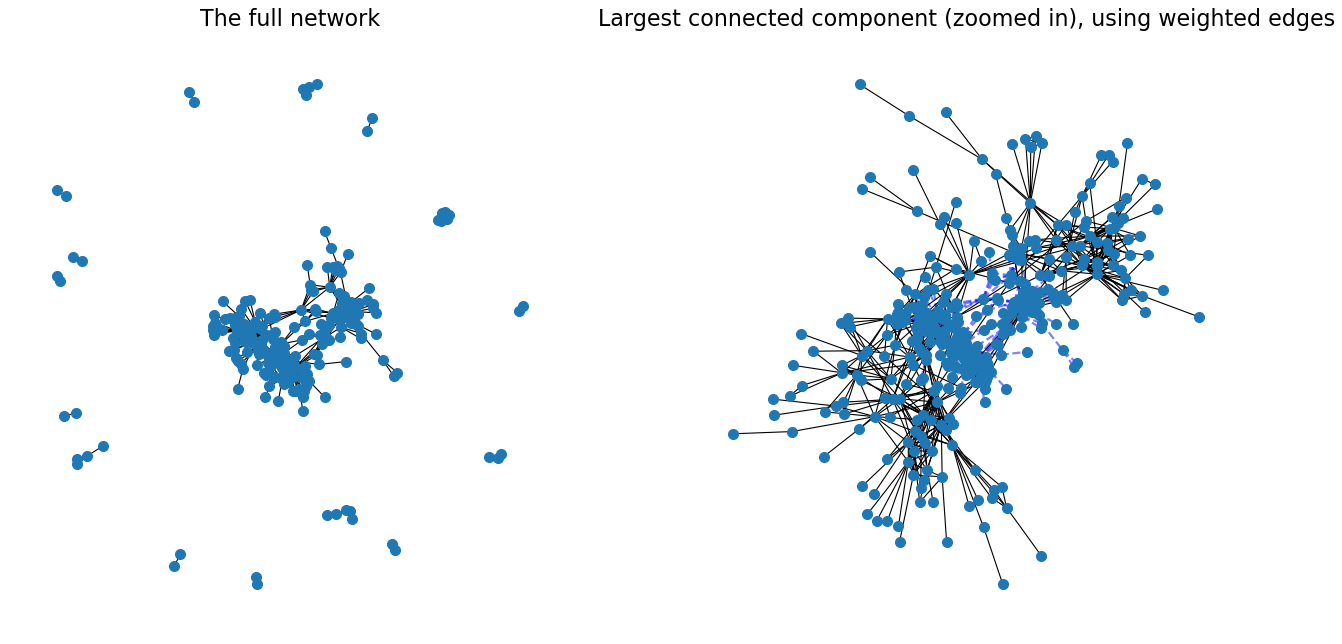

In [23]:
# YOU CAN EDIT THIS TO CHANGE THE USED META-PATH
selected_metapath = "BIB"

(df, names_df, attributes_df, hg) = hintohg.init_data(selected_metapath, metapaths)
vizualisation.draw_hg(hg)

<h1>Creating snapshot graph and performing dynamic community detection</h1>

In [31]:
interval = 20
shift = 10
theta = 0.3

snapshot_graph = dynamic_cd.create_snapshot_graph(hg, interval, shift, names_df)
(dcd_results_init_partition, tc, snapshots, snapshot_times) = dynamic_cd.execute_dcd(snapshot_graph, f"{interval}_{shift}")
dynamic_coms, com_events = dynamic_cd.matching(tc, theta)

df_folder = Path("./data/dynamic_coms")

# with open(df_folder / (selected_metapath + "_tc.pickle"), 'wb') as handle:
#     pickle.dump(tc, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(df_folder / (selected_metapath + "_dynamic_coms.pickle"), 'wb') as handle:
#     pickle.dump(dynamic_coms, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(df_folder / (selected_metapath + "_dynamic_coms.pickle"), 'rb') as handle:
    dynamic_coms = pickle.load(handle)

with open(df_folder / (selected_metapath + "_tc.pickle"), 'rb') as handle:
    tc = pickle.load(handle)


Interval: 20, Stepsize: 10
Num of snapshots: 27
Handling sg with parameters: 20_10
MERGING [6, 7]
MERGING [22, 23]
SPLITTING 21 (12_3) into 21 (13_4) and 34 (13_5)
MERGING [37, 43]
MERGING [9, 49]
MERGING [52, 61]
SPLITTING 67 (21_3) into 67 (22_1) and 73 (22_7)
SPLITTING 74 (23_0) into 74 (24_0) and 76 (24_1)


<h1>RESULTS: follow a person through time, edit "name"</h1>

NAME TO FIND: Zacharias Webber

TIMESTEP: 11
DYNAMIC COMMUNITY: 22
INTERVAL (1647, 1667)


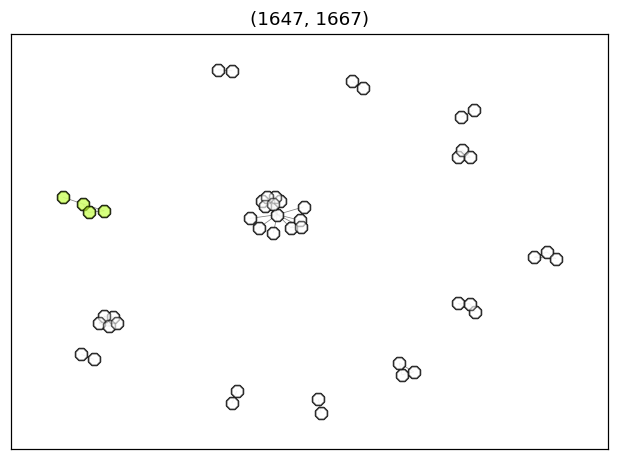

Jan Jansz. Veenhuysen - Centrality: 0.065 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
Zacharias Webber - Centrality: 0.043 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Abraham Blooteling - Centrality: 0.043 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/1061
Jacob Willems van Meurs - Centrality: 0.022 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/5223
---------------------------------------------------------------
TIMESTEP: 12
DYNAMIC COMMUNITY: 22
INTERVAL (1657, 1677)


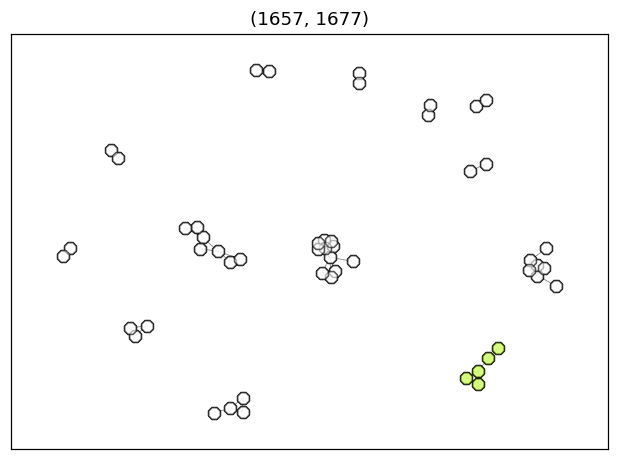

Jan Jansz. Veenhuysen - Centrality: 0.06 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
Zacharias Webber - Centrality: 0.04 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jacob Willems van Meurs - Centrality: 0.04 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/5223
Abraham Blooteling - Centrality: 0.04 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/1061
Arnoldus Montanus - Centrality: 0.02 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/53229

MERGED WITH:
23
#############################################
Philips Davidsz Vingboons - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7873
Jacob van Campen - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/1616
Jacob Vennekool - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7660
#############################################
-------------------------------------------------------------

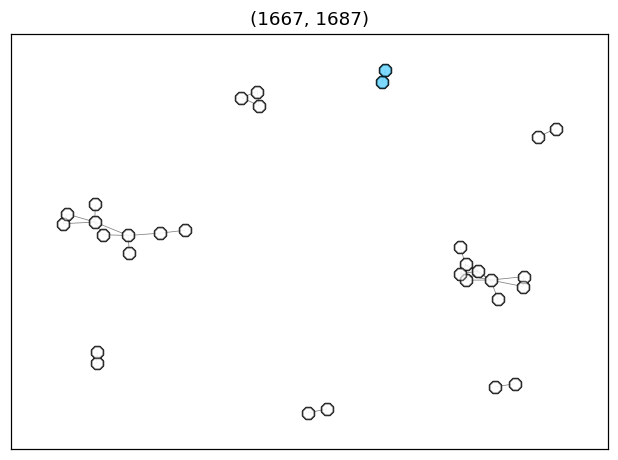

Zacharias Webber - Centrality: 0.033 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.033 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 14
DYNAMIC COMMUNITY: 35
INTERVAL (1677, 1697)


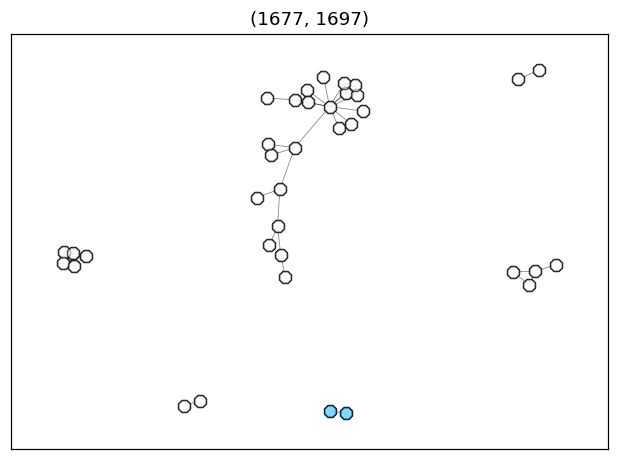

Zacharias Webber - Centrality: 0.028 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.028 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 16
DYNAMIC COMMUNITY: 35
INTERVAL (1697, 1717)


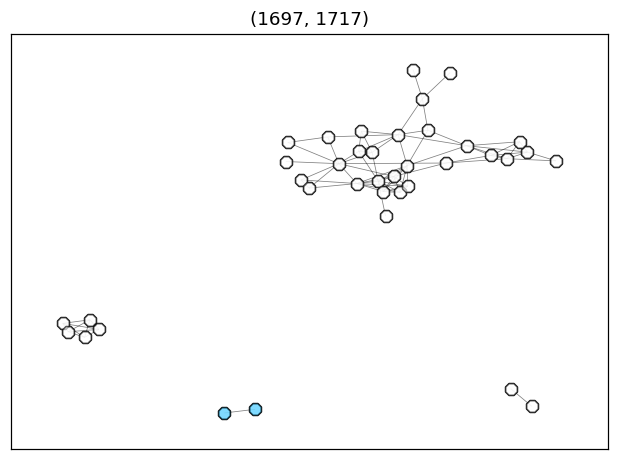

Zacharias Webber - Centrality: 0.027 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.027 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 17
DYNAMIC COMMUNITY: 35
INTERVAL (1707, 1727)


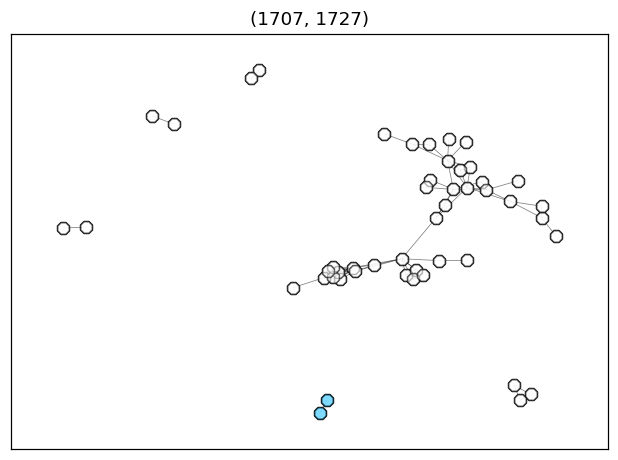

Zacharias Webber - Centrality: 0.021 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.021 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 19
DYNAMIC COMMUNITY: 35
INTERVAL (1727, 1747)


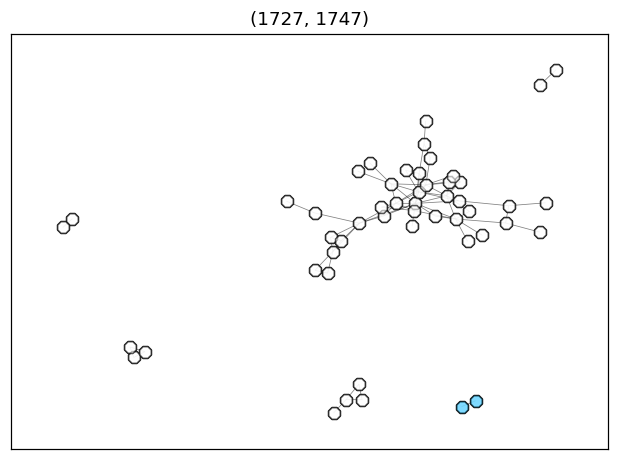

Zacharias Webber - Centrality: 0.02 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.02 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 20
DYNAMIC COMMUNITY: 35
INTERVAL (1737, 1757)


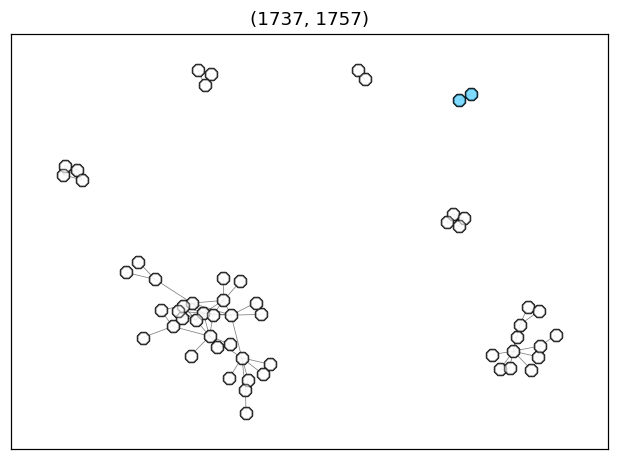

Zacharias Webber - Centrality: 0.018 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.018 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------


In [32]:
# EDIT THIS
name = "Zacharias Webber"

res = dynamic_cd.find_dyn_com(dynamic_coms, name, tc, snapshots, snapshot_times, names_df, com_events)

In [41]:
# filtered_dynamic_coms = dict(filter(lambda x: len(x[1]) > 2, dynamic_coms.items()))
# print(len(filtered_dynamic_coms))
# for dyn_com_id, dyn_com in filtered_dynamic_coms.items():
#     union_com = dynamic_cd.get_community_union(tc, snapshots, snapshot_times, dynamic_coms, dyn_com_id)
#     # print(len(union_com))
#     print(f"{dyn_com_id}: {dyn_com}")

25
6: ['6_3', '7_3', '8_4']
7: ['6_4', '7_3', '8_4']
8: ['7_0', '8_1', '9_0', '10_1']
13: ['9_3', '10_6', '18_6', '19_4']
14: ['9_5', '10_3', '20_6', '21_5']
17: ['9_8', '10_9', '11_13']
19: ['10_4', '11_0', '12_5']
22: ['11_3', '12_3', '13_4']
23: ['11_4', '12_1', '13_2']
24: ['11_5', '12_1', '13_2']
26: ['11_7', '12_4', '13_0', '14_3']
31: ['12_2', '13_1', '14_4']
35: ['11_3', '12_3', '13_5', '14_6', '16_5', '17_8', '19_7', '20_10']
37: ['14_0', '15_2', '16_3']
38: ['14_1', '15_3', '16_6']
39: ['14_2', '15_1', '17_1', '18_3']
43: ['15_4', '16_2', '22_3']
44: ['16_1', '17_1', '18_3']
50: ['17_6', '18_6', '19_4']
55: ['18_5', '19_6', '20_8']
58: ['19_1', '20_2', '21_2', '22_3']
62: ['19_1', '20_4', '21_0', '22_0', '23_3', '24_2', '25_0']
65: ['20_9', '21_7', '22_6']
67: ['21_6', '22_2', '23_2']
73: ['23_0', '24_0', '25_1']


<h1>RESULTS: follow a dynamic community based on the dynamic community id, edit "dyn_com_id"</h1>

Timestep: 19, Period: (1727, 1747)


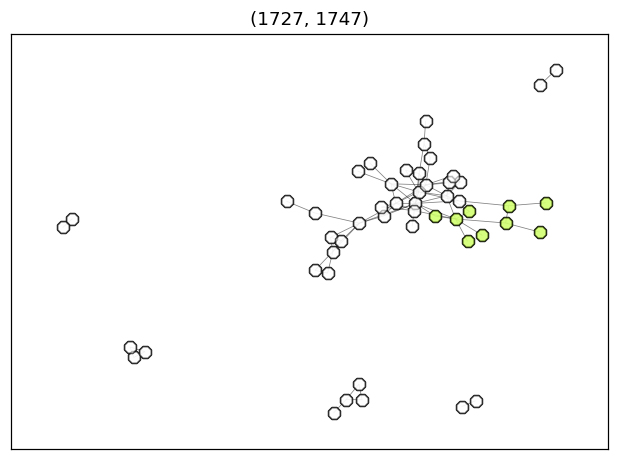

Adolf van der Laan - Centrality: 0.16 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/4413
Simon Fokke - Centrality: 0.06 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52372
Jan Punt de Jonge - Centrality: 0.06 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52346
Johannes Lamsvelt de jonge - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/4457
Jacobus van der Schley - Centrality: 0.04 - URI: http://data.bibliotheken.nl/id/thes/p069754454
Jacobus de Later - Centrality: 0.02 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/4494
Daniël Stopendael - Centrality: 0.02 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7170
Cornelis Jacobsz. Drebbel - Centrality: 0.02 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/2588
Charles-Antoine Coypel - Centrality: 0.02 - URI: http://data.bibliotheken.nl/id/thes/p068201559
---------------------------------------------------------------
Timestep: 20, Per

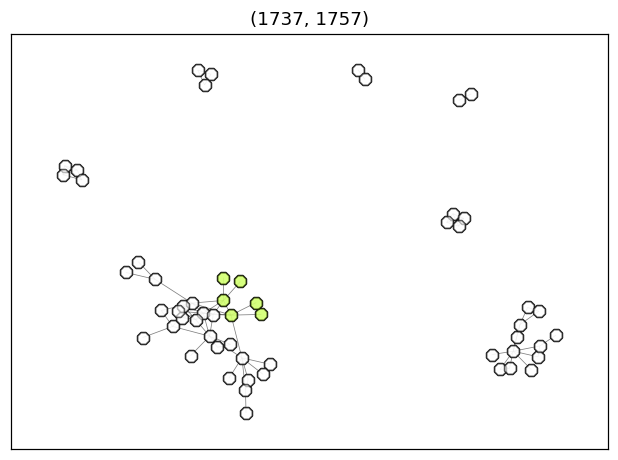

Simon Fokke - Centrality: 0.125 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52372
Jan Punt de Jonge - Centrality: 0.107 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52346
Cornelis Pronk - Centrality: 0.018 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/8862
Cornelis Jacobsz. Drebbel - Centrality: 0.018 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/2588
Charles-Antoine Coypel - Centrality: 0.018 - URI: http://data.bibliotheken.nl/id/thes/p068201559
Allart Pietersz. van Everdingen - Centrality: 0.018 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/2805
---------------------------------------------------------------
Timestep: 21, Period: (1747, 1767)


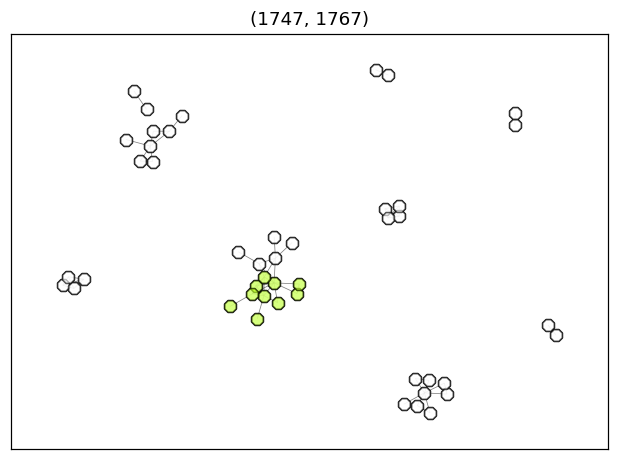

Jacob Houbraken - Centrality: 0.2 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/10178
Simon Fokke - Centrality: 0.133 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52372
Aert Schouman - Centrality: 0.133 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52482
Jan Punt de Jonge - Centrality: 0.111 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52346
Jan Wandelaar - Centrality: 0.089 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/13878
Reinier Vinkeles - Centrality: 0.044 - URI: http://data.bibliotheken.nl/id/thes/p070362858
P. van Liender - Centrality: 0.044 - URI: http://data.bibliotheken.nl/id/thes/p089364805
Jacobus Buys - Centrality: 0.044 - URI: http://data.bibliotheken.nl/id/thes/p091493323
Cornelis Jacobsz. Drebbel - Centrality: 0.022 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/2588
Allart Pietersz. van Everdingen - Centrality: 0.022 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/2805
---

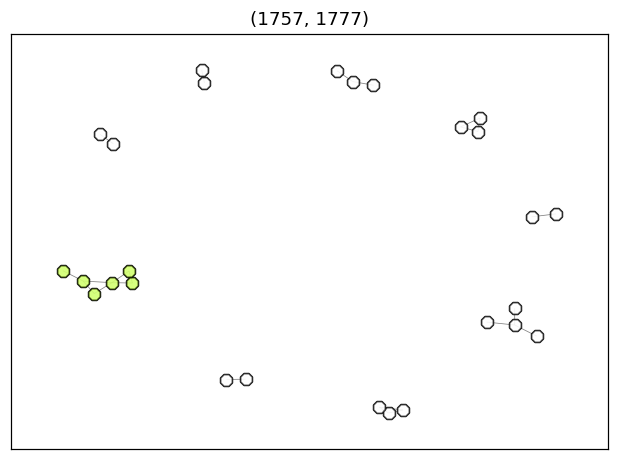

Jacob Houbraken - Centrality: 0.154 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/10178
Simon Fokke - Centrality: 0.115 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52372
Reinier Vinkeles - Centrality: 0.077 - URI: http://data.bibliotheken.nl/id/thes/p070362858
P. van Liender - Centrality: 0.077 - URI: http://data.bibliotheken.nl/id/thes/p089364805
Jacobus Buys - Centrality: 0.077 - URI: http://data.bibliotheken.nl/id/thes/p091493323
Pieter Anthonisz. Barbiers - Centrality: 0.038 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/10461
---------------------------------------------------------------
Timestep: 23, Period: (1767, 1787)


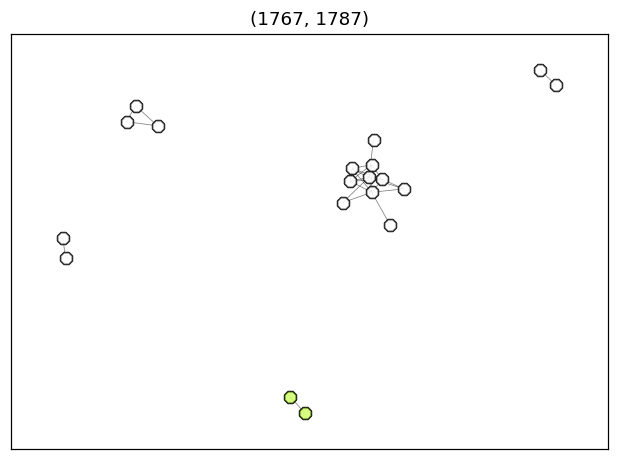

Reinier Vinkeles - Centrality: 0.056 - URI: http://data.bibliotheken.nl/id/thes/p070362858
Jacob Houbraken - Centrality: 0.056 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/10178
---------------------------------------------------------------
Timestep: 24, Period: (1777, 1797)


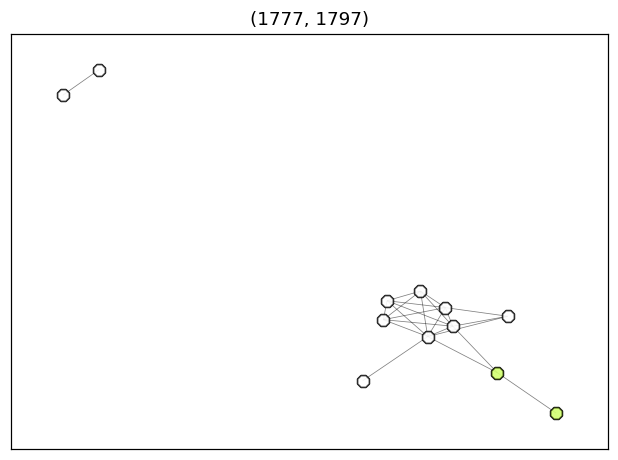

Jan Punt de Jonge - Centrality: 0.273 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52346
Reinier Vinkeles - Centrality: 0.091 - URI: http://data.bibliotheken.nl/id/thes/p070362858
---------------------------------------------------------------
Timestep: 25, Period: (1787, 1807)


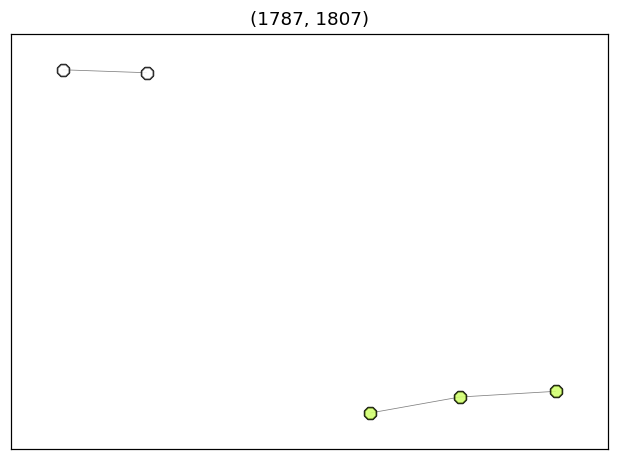

Reinier Vinkeles - Centrality: 0.5 - URI: http://data.bibliotheken.nl/id/thes/p070362858
Jan Punt de Jonge - Centrality: 0.25 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/52346
Jan Bulthuis - Centrality: 0.25 - URI: http://data.bibliotheken.nl/id/thes/p089235193
---------------------------------------------------------------


In [37]:
# EDIT THIS
dynamic_com_id = 62

# 62


dynamic_cd.print_dyn_com(dynamic_coms, dynamic_com_id, tc, snapshots, snapshot_times, names_df, com_events)

<h1>RESULTS: produce a description of a dynamic community, edit "dyn_com_id"</h1>

In [ ]:
# EDIT THIS
dynamic_com_id = 18


union_com = dynamic_cd.get_community_union(tc, snapshots, snapshot_times, dynamic_coms, dynamic_com_id)
print(f"Number of people in the community: {len(union_com)}")
description.get_community_description(union_com, attributes_df)

Number of people in the community: 4


{'Birthplace': ('Antwerpen', 50.0),
 'Religion': ('Reformed', 56.03),
 'Occupation': ('letterpress printer', 33.33),
 'Occupational Address': ('Leiden', 50.0),
 'Family Relation': ('Catharina Jacquet', 8.33),
 'Birthday': 1533}